In [1]:
import tensorflow as tf
import numpy as np
import cv2

import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [2]:
def get_part_from_image(image, scale = 1.3):
    blurred = cv2.pyrMeanShiftFiltering(image, 10, 10)
    imgray = cv2.cvtColor(blurred,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,157,255,0)
    im2,contours,hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours
    contour_indexer = 0
    i = 0
    #for c in cnt[1:]:
    #    i = i + 1
    #    if len(c)>len(cnt[contour_indexer]):
    #        contour_indexer = i
    filteredContours = []
    for c in cnt:
        if len(c) > 50:
            filteredContours.append(c)

    if len(filteredContours) > 0:
        merged_contours = np.concatenate(filteredContours)

        (x,y),radius = cv2.minEnclosingCircle(merged_contours)
        center = (int(x),int(y))
        radius = int(radius)
        scaled_rad = int(radius * scale)
        try:
            img_cutted = image[center[1] - scaled_rad : center[1] + scaled_rad,
                               center[0] - scaled_rad : center[0] + scaled_rad,
                               : ] 
        except:
            img_cutted = image[center[1] - radius : center[1] + radius,
                               center[0] - radius : center[0] + radius,
                               : ] 

        return img_cutted
    else:
        return None

In [60]:
from layers import conv_layer, max_pool_2x2, full_layer

home = os.getcwd().split('AUT-CNN-TUB')[0]
model_path  = os.path.join(home,'AUT-CNN-TUB', 'Data', 'Models', 'model.ckpt')


DATA_DIR = '/tmp/data'
MINIBATCH_SIZE = 100
STEPS = 50000

home = os.getcwd().split('AUT-CNN-TUB')[0]
test_path  = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_28/test/')
train_path = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_28/train/')

labels = ['001', '002', '003', '004', '006', '071', '072']
position_dict = {k: v for v, k in enumerate(labels)}
label_dict = {v : k  for v, k in enumerate(labels)}

def label_to_binary(position_dict, label):
    z = np.zeros(len(position_dict), dtype=int)
    z[position_dict[label]] =1
    return z

def next_batch(path, size, GRBtoGray=False, flatten=False):
    
    data_path = os.path.join(path, '*g')  # ???
    files = glob.glob(data_path)
    num_imag = len(files)
    Data = np.arange(0, num_imag)
    batchindices = np.random.choice(Data, size=size,
                                    replace=False)  # Zufallsstichprobe; reihenfolge beliebig; ohne zurückl.
    
    print(len(batchindices))

    label_list =[]
    img_list = []
    for i, file_path in enumerate(files):
        if i in batchindices:
            label_str = file_path.split('/')[-1].split('.')[0][:3]
            label_bin = label_to_binary(position_dict, label_str)

            if GRBtoGray == True:
                img = cv2.imread(file_path, flags=0)
            else:
                img = cv2.imread(file_path, flags=1)

            if flatten == True:
                img_list.append(img.flatten())
                label_list.append(label_bin)
            else:
                img_list.append(img)
                label_list.append(label_bin)

    img_list = np.array(img_list)
    label_list = np.array(label_list)


    return img_list, label_list


class Test:
    def __init__(self, path, GRBtoGray=False, flatten=False): 
        self.path  = path
        self.GRBtoGray  = GRBtoGray
        self.flatten  = flatten
        self.batchindices = None
        
        self.data_path = os.path.join(self.path, '*g')  # ???
        self.files = glob.glob(self.data_path)
        self.num_imag = len(self.files)
        self.Data = list(range(0, self.num_imag))

    def get_batch(self,size):
        
        if len(self.Data) > size:
            self.batchindices = list(np.random.choice(self.Data, size=size, replace=False))
            for x in self.batchindices:
                self.Data.remove(x) 
                
        elif len(self.Data) == size:
            self.batchindices = np.random.choice(self.Data, size=size, replace=False)  
            self.Data = list(range(0, self.num_imag))

            
        else:
            self.batchindices = np.random.choice(self.Data, size=len(self.Data), replace=False)  
            self.Data = list(range(0, self.num_imag))



            

        label_list =[]
        img_list = []
        file_name_list = []
        for i, file_path in enumerate(self.files):
            if i in self.batchindices:
                label_str = file_path.split('/')[-1].split('.')[0][:3]
                label_bin = label_to_binary(position_dict, label_str)

                if self.GRBtoGray == True:
                    img = cv2.imread(file_path, flags=0)
                else:
                    img = cv2.imread(file_path, flags=1)

                if self.flatten == True:
                    img_list.append(img.flatten())
                    label_list.append(label_bin)
                    file_name_list.append(file_path.split('/')[-1])
                else:
                    img_list.append(img)
                    label_list.append(label_bin)
                    file_name_list.append(file_path.split('/')[-1])

        img_list = np.array(img_list)
        label_list = np.array(label_list)


        return img_list, label_list, file_name_list


In [64]:
tf.reset_default_graph()
# Create some variables.
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 3])
y_ = tf.placeholder(tf.float32, shape=[None, len(position_dict)])

#x_image = tf.reshape(x, [-1, 28, 28, 1])
conv1 = conv_layer(x, shape=[5, 5, 3, 64])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 64, 128])
conv2_pool = max_pool_2x2(conv2)

conv2_flat = tf.reshape(conv2_pool, [-1, 7*7*128])
full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))

keep_prob = tf.placeholder(tf.float32)
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, len(position_dict))

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# Add ops to save and restore only `v2` using the name "v2"
saver = tf.train.Saver()


# Use the saver object normally after that.
with tf.Session() as sess:
    # Initialize v1 since the saver will not.
    #v1.initializer.run()
    saver.restore(sess, model_path)

    X_batch, y_batch, file_name = test_img.get_batch(2723)

    test_accuracy = np.mean(sess.run(accuracy, feed_dict={x: X_batch, y_: y_batch, keep_prob: 1.0}))

    print("test accuracy: {}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from /home/jeronimo/git/AUT-CNN-TUB/Data/Models/model.ckpt
test accuracy: 0.993756890296936


INFO:tensorflow:Restoring parameters from /home/jeronimo/git/AUT-CNN-TUB/Data/Models/model.ckpt
test accuracy: 0.993756890296936
003 ['002020039.jpg']
[[ -37.462364  114.26223   396.55664   334.78558   -60.60667  -357.95383
  -614.7165  ]]


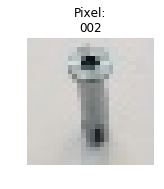

004 ['002020041.jpg']
[[-133.77478  409.0514   126.77707  588.0451  -168.81038 -455.9283
  -867.52185]]


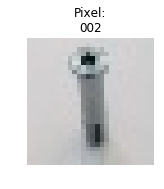

006 ['072020123.jpg']
[[   18.010153  -496.34103    487.12573    313.7928     819.66095
  -1221.3838     299.28125 ]]


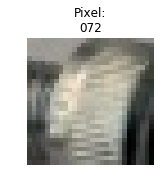

003 ['072020047.jpg']
[[-321.1412    104.4386    171.04042   147.57013  -593.50574    65.962395
   160.73222 ]]


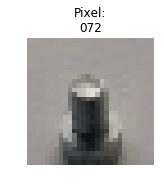

002 ['004020127.jpg']
[[-390.3707   466.5662   314.66638 -370.1122  -463.74615 -447.20856
  -191.72063]]


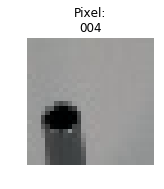

002 ['072020133.jpg']
[[-160.4514   505.94012  308.48602 -814.5477  -123.92466 -209.72218
   -42.03921]]


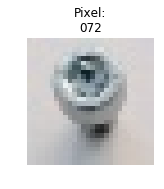

003 ['071020022.jpg']
[[-499.4879    72.97882  666.891   -480.409   -147.34012  418.09888
  -376.12442]]


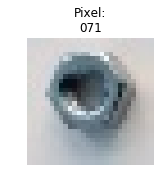

003 ['072010237.jpg']
[[ -14.137429 -181.41472   279.9759    -59.791462 -145.20403   -35.83226
   189.82355 ]]


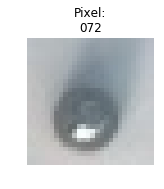

004 ['072020116.jpg']
[[-374.7539     26.033754  140.78973   559.4568   -528.16406  -628.9969
    82.739525]]


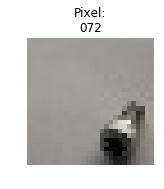

071 ['072020266.jpg']
[[-292.26602 -284.83612   39.10654 -400.47147 -364.9169   378.44623
   222.90332]]


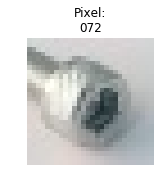

003 ['001020150.jpg']
[[ 410.6416   -139.77971   473.43088  -304.16345   -82.33945   -11.487098
   -32.570404]]


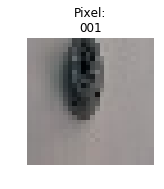

001 ['072020180.jpg']
[[  878.29364   139.33409    78.71622 -1583.9802   -709.8051    -97.85704
    795.6849 ]]


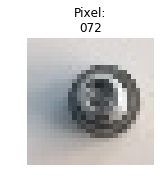

002 ['072020132.jpg']
[[ -253.049      450.27072     81.546364 -1199.1794    -146.61559
   -222.06496    449.5701  ]]


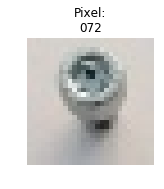

003 ['072010765.jpg']
[[-111.74461   -243.50157    319.26468      7.2922335  -69.96499
    46.877316   211.20638  ]]


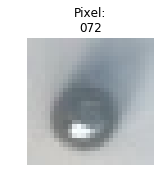

004 ['003010577.jpg']
[[  322.79535  -563.89307  1191.9814   1392.5564   -487.22318   397.65833
  -1244.0895 ]]


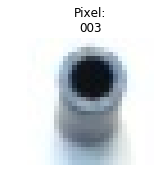

004 ['003020228.jpg']
[[  423.56503    216.62961   1055.264     1144.8109   -1034.2036
    -49.880123 -1763.0802  ]]


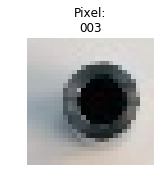

003 ['072020114.jpg']
[[-302.81732  -351.00998   509.7305   -309.44     -389.7482    126.47545
    55.353214]]


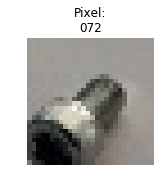

In [62]:
tf.reset_default_graph()
# Create some variables.
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 3])
y_ = tf.placeholder(tf.float32, shape=[None, len(position_dict)])

#x_image = tf.reshape(x, [-1, 28, 28, 1])
conv1 = conv_layer(x, shape=[5, 5, 3, 64])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 64, 128])
conv2_pool = max_pool_2x2(conv2)

conv2_flat = tf.reshape(conv2_pool, [-1, 7*7*128])
full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))

keep_prob = tf.placeholder(tf.float32)
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, len(position_dict))

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# Add ops to save and restore only `v2` using the name "v2"
saver = tf.train.Saver()

test_img = Test(test_path, False, False)

# Use the saver object normally after that.
with tf.Session() as sess:
    saver.restore(sess, model_path)

    X_batch, y_batch, file_name = test_img.get_batch(2723)
    test_accuracy = np.mean([sess.run(accuracy, feed_dict={x: X_batch, y_: y_batch, keep_prob: 1.0})])

    print("test accuracy: {}".format(test_accuracy))
    
    for i in range(2723):

        X_batch, y_batch, file_name = test_img.get_batch(1)

        label = y_batch
        image_ar = X_batch[0]
        if label_dict[np.argmax(sess.run(tf.nn.softmax(y_conv, 1),
                                         feed_dict={x: X_batch,
                                                    y_: y_batch, 
                                                    keep_prob: 1}))] != label_dict[np.argmax(label)]:
            
            print(label_dict[np.argmax(sess.run(
                tf.nn.softmax(y_conv, 1), 
                feed_dict={x: X_batch, y_: y_batch, keep_prob: 1}))], file_name)
            print(sess.run(tf.cast(y_conv, 1), feed_dict={x: X_batch, y_: y_batch, keep_prob: 1}))




            fig = plt.figure(figsize=(5,5))
            ax1 = fig.add_subplot(1, 2, 1)
            ax1.axis('off')
            ax1.set_title('Pixel:\n' + label_dict[np.argmax(label)])
            ax1.imshow(image_ar);
            plt.show()

In [54]:
for x in test_img.batchindices:
    print(x)

2619


In [59]:
test_img.Data.pop(0)


1

### load raw image for testing

In [65]:
home = os.getcwd().split('AUT-CNN-TUB')[0]
test_path  = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_28/test/')
data_path = os.path.join(test_path, '*g')  # ???

files = glob.glob(data_path)
num_imag = len(files)
Data = np.arange(0, num_imag)
len(files)

2723

In [72]:
file_path = '/home/jeronimo/git/AUT-CNN-TUB/Data/Raw_Data/1/001010031.jpg'
label_str = file_path.split('/')[-1].split('.')[0][:3]
label_bin = label_to_binary(position_dict, label_str)

label_list =[]
img_list = []

img = cv2.imread(file_path, flags=1)
img = get_part_from_image(img, scale = 1.3)
img = cv2.resize(img,(28, 28))
#img = cv2.flip( img, flipCode=1)
img_rot = np.rot90(img)
img_list.append(img)
label_list.append(label_bin)


img_list = np.array(img_list)
label_list = np.array(label_list)

001


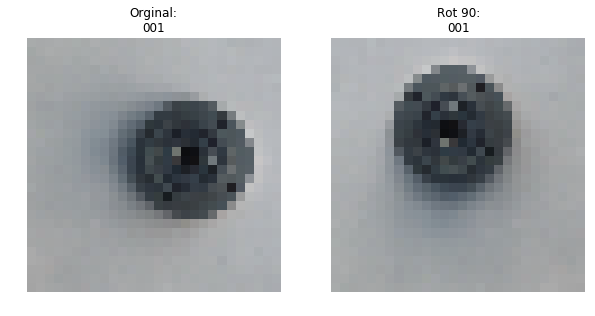

In [75]:
print(label_str)
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title('Orginal:\n' + label_str)
ax1.imshow(img);
ax2 = fig.add_subplot(1, 2, 2)
ax2.axis('off')
ax2.set_title('Rot 90:\n' + label_str)
ax2.imshow(img_rot);
plt.show()


INFO:tensorflow:Restoring parameters from /home/jeronimo/git/AUT-CNN-TUB/Data/Models/model.ckpt
002
[[ -29.984785   390.07068    251.70288   -343.12512      1.9317305
  -109.81803    -87.08603  ]]


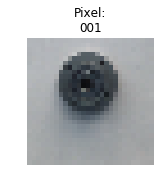

In [71]:
tf.reset_default_graph()
# Create some variables.
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 3])
y_ = tf.placeholder(tf.float32, shape=[None, len(position_dict)])

#x_image = tf.reshape(x, [-1, 28, 28, 1])
conv1 = conv_layer(x, shape=[5, 5, 3, 64])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 64, 128])
conv2_pool = max_pool_2x2(conv2)

conv2_flat = tf.reshape(conv2_pool, [-1, 7*7*128])
full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))

keep_prob = tf.placeholder(tf.float32)
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, len(position_dict))

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# Add ops to save and restore only `v2` using the name "v2"
saver = tf.train.Saver()

test_img = Test(test_path, False, False)

# Use the saver object normally after that.
with tf.Session() as sess:
    saver.restore(sess, model_path)

    label = label_list[0]
    image_ar = img_list[0]
    y_batch = label_list
    X_batch = img_list
    
    print(label_dict[np.argmax(sess.run(
        tf.nn.softmax(y_conv, 1), 
        feed_dict={x: X_batch, y_: y_batch, keep_prob: 1}))])
    print(sess.run(tf.cast(y_conv, 1), feed_dict={x: X_batch, y_: y_batch, keep_prob: 1}))




    fig = plt.figure(figsize=(5,5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.axis('off')
    ax1.set_title('Pixel:\n' + label_dict[np.argmax(label)])
    ax1.imshow(image_ar);
    plt.show()